In [1]:
import pandas as pd
import pandas.io.sql as sqlio

from bs4 import BeautifulSoup
from urllib.request import urlopen
import urllib.request
import requests
import time 
from multiprocessing import Process, Queue, Pool
import threading
import sys
import numpy as np
import re

from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.common.by import By

from selenium.webdriver.chrome.options import Options
import pandasql as ps
from IPython.display import display,HTML
from datetime import date
from datetime import datetime
import matplotlib.pyplot as plt 

In [2]:
def san_pablo(marca):
    path ="C:\webdriver\chromedriver.exe" # carga del web driver (asignar ruta donde se encuentra el driver)
    driver=webdriver.Chrome(path)

    url="https://www.farmaciasanpablo.com.mx/search/" + marca
    driver.get(url) # instruccion de obtener url parametrizada
    
    time.sleep(12) # dormir equipo para carga de pagina
# se busca clase que contiene todos los items mostrados en la pagina
    productos=driver.find_elements_by_class_name("col-md-3.col-lg-3.col-sm-6.col-6")
    
    lista_nombres=[]
    for i in range(0,len(productos)):
        try:
            lista_nombres.append(productos[i].find_elements_by_class_name("nameProduct")[0].text)
        except:
            lista_nombres.append(np.nan)
            
# asignacion de precios recientes (con descuento)
    lista_precios=[]
    for i in range(0,len(productos)):
        try:
            lista_precios.append(productos[i].find_elements_by_class_name("col-md-11.col-lg-11.col-sm-11.col-11.price")[0].text)
        except:
            lista_precios.append(np.nan)
   
            
#precio sin descuento
    lista_precios_sin_descuento=[]
    for i in range(0,len(productos)):
        try:
            lista_precios_sin_descuento.append(productos[i].find_elements_by_class_name("discount")[0].text)
        except:
            lista_precios_sin_descuento.append(np.nan)
    
# creacion de data frame
    today = date.today()

    df_sp =pd.DataFrame(columns=["NOMBRE","MARCA","PRECIO","PRECIO_SIN_DESCUENTO","DISPONIBILIDAD","AUTOSERVICIO","FECHA"])
    df_sp["NOMBRE"] = lista_nombres
    df_sp["MARCA"] = marca
    df_sp["PRECIO"] = lista_precios
    df_sp["PRECIO_SIN_DESCUENTO"]=lista_precios_sin_descuento
    df_sp["DISPONIBILIDAD"] = "Desconocido"
    df_sp["AUTOSERVICIO"] = "www.farmaciasanpablo.com.mx"
    df_sp["FECHA"] = str(today)
    
    df_sp.PRECIO = df_sp.PRECIO.str.replace("MXN","")
    df_sp.PRECIO = df_sp.PRECIO.str.replace("$","")
    df_sp.PRECIO = df_sp.PRECIO.str.replace(",","")
    df_sp.PRECIO = df_sp.PRECIO.astype(float) # cast de datos
    
    try:
        df_sp.PRECIO_SIN_DESCUENTO = df_sp.PRECIO_SIN_DESCUENTO.str.replace("MXN","")
        df_sp.PRECIO_SIN_DESCUENTO = df_sp.PRECIO_SIN_DESCUENTO.str.replace("$","")
        df_sp.PRECIO_SIN_DESCUENTO= df_sp.PRECIO_SIN_DESCUENTO.str.replace(",","")
        df_sp.PRECIO_SIN_DESCUENTO= df_sp.PRECIO_SIN_DESCUENTO.astype(float) # cast de datos
    except:
        pass

    driver.quit()
    return df_sp

def farmazone(marca):
    #Hacemos las funciones del sitio 2
    path ="C:\webdriver\chromedriver.exe" # carga del web driver (asignar ruta donde se encuentra el driver)
    driver=webdriver.Chrome(path)

    url="https://www.farmazone.com.mx/busqueda/" + marca
    driver.get(url) # instruccion de obtener url parametrizada

    time.sleep(12) # dormir equipo para carga de pagina

    ## se busca clase que contiene todos los items mostrados en la pagina
    productos=driver.find_elements_by_class_name("product-box")
    
    # asignacion de nombres
    lista_nombres=[]
    for i in range(0,len(productos)):
        try:
            lista_nombres.append(productos[i].find_elements_by_class_name("product-text")[0].text)
        except:
            lista_nombres.append(np.nan)
    
    # asignacion de precios recientes (con descuento)
    lista_precios=[]
    for i in range(0,len(productos)):
        try:
            lista_precios.append(productos[i].find_elements_by_class_name("product-price")[0].text)
        except:
            lista_precios.append(np.nan)

    today = date.today()
    
    
    #asignacion de precios sin descuento
    lista_precios_sin_descuento=[]
    for i in range(0,len(productos)):
        try:
            lista_precios_sin_descuento.append(productos[i].find_elements_by_class_name("product-price-discount")[0].text)
        except:
            lista_precios_sin_descuento.append(np.nan)
            
    #asignacion de disponibilidad en el sitio
    lista_disponibilidad=[]
    for i in range(0,len(productos)):
        try:
            lista_disponibilidad.append(productos[i].find_elements_by_class_name("cart-warning-message")[0].text)
        except:
            lista_disponibilidad.append("Producto disponible")

    today = date.today()
    
    # creacion de data frame
    df_farmazone=pd.DataFrame(columns=["NOMBRE","MARCA","PRECIO","PRECIO_SIN_DESCUENTO","DISPONIBILIDAD","AUTOSERVICIO","FECHA"])
    df_farmazone["NOMBRE"] = lista_nombres
    df_farmazone["MARCA"] = marca
    df_farmazone["PRECIO"] = lista_precios
    df_farmazone["PRECIO_SIN_DESCUENTO"] = lista_precios_sin_descuento
    df_farmazone["DISPONIBILIDAD"] = lista_disponibilidad
    df_farmazone["AUTOSERVICIO"] = "www.farmazone.com.mx"
    df_farmazone["FECHA"] = str(today)

    
    df_farmazone.PRECIO = df_farmazone.PRECIO.str.replace("$","")
    df_farmazone.PRECIO = df_farmazone.PRECIO.str.replace(",","")
    df_farmazone.PRECIO = df_farmazone.PRECIO.astype(float) # cast de datos
    
    try:
        df_farmazone.PRECIO_SIN_DESCUENTO = df_farmazone.PRECIO_SIN_DESCUENTO.str.replace("$","")
        df_farmazone.PRECIO_SIN_DESCUENTO= df_farmazone.PRECIO_SIN_DESCUENTO.str.replace(",","")
        df_farmazone.PRECIO_SIN_DESCUENTO= df_farmazone.PRECIO_SIN_DESCUENTO.astype(float) # cast de datos
    except:
        pass
    
    driver.quit()
    return df_farmazone


def farmalisto(marca):
    
    #Hacemos las funciones del sitio 3
    path ="C:\webdriver\chromedriver.exe" # carga del web driver (asignar ruta donde se encuentra el driver)
    driver=webdriver.Chrome(path)
    
    url="https://www.farmalisto.com.mx/#/dffullscreen/query=" + marca + "&session_id=cb212d6817b714181999c75d3044b34b&query_name=match_and"
    driver.get(url) # instruccion de obtener url parametrizada
    time.sleep(12) # dormir equipo para carga de pagina

    ## se busca clase que contiene todos los items mostrados en la pagina
    productos=driver.find_elements_by_class_name("df-card__content")

   # asignacion de nombres
    lista_nombres=[]
    for i in range(0,len(productos)):
        try:
            lista_nombres.append(productos[i].find_elements_by_class_name("df-card__title.dooSearchDefaultTitle")[0].text)
        except:
            lista_nombres.append(np.nan)
            
    # asignacion de precios sin descuento
    lista_precios_sin_descuento=[]
    for i in range(0,len(productos)):
        try:
            lista_precios_sin_descuento.append(productos[i].find_elements_by_class_name("df-card__price.df-card__price--old")[0].text)
        except:
            lista_precios_sin_descuento.append(np.nan)
            
    # asignacion de precios recientes 
            
    lista_precios=[]
    for i in range(0,len(productos)):
        try:
            lista_precios.append(productos[i].find_elements_by_class_name("df-card__price")[0].text)
        except:
            lista_precios.append(np.nan)
            
    # creacion de data frame
    today = date.today()
    df_farmalisto =pd.DataFrame(columns=["NOMBRE","MARCA","PRECIO","PRECIO_SIN_DESCUENTO", "DISPONIBILIDAD","AUTOSERVICIO","FECHA"])
    df_farmalisto["NOMBRE"] = lista_nombres
    df_farmalisto["MARCA"] = marca
    df_farmalisto["PRECIO"] = lista_precios
    df_farmalisto["PRECIO_SIN_DESCUENTO"] = lista_precios_sin_descuento
    df_farmalisto["DISPONIBILIDAD"] = "Desconocido"
    df_farmalisto["AUTOSERVICIO"] = "www.farmalisto.com.mx"
    df_farmalisto["FECHA"] = str(today)

    
    df_farmalisto.PRECIO = df_farmalisto.PRECIO.str.replace("$","")
    df_farmalisto.PRECIO = df_farmalisto.PRECIO.str.replace(",","")
    df_farmalisto.PRECIO = df_farmalisto.PRECIO.astype(float) # cast de datos
    
    try:
        df_farmalisto.PRECIO_SIN_DESCUENTO = df_farmalisto.PRECIO_SIN_DESCUENTO.str.replace("$","")
        df_farmalisto.PRECIO_SIN_DESCUENTO = df_farmalisto.PRECIO_SIN_DESCUENTO.str.replace(",","")
        df_farmalisto.PRECIO_SIN_DESCUENTO = df_farmalisto.PRECIO_SIN_DESCUENTO.astype(float) # cast de datos
    except:
        pass
        
    driver.quit()
    
    return df_farmalisto


In [3]:
busqueda1 = san_pablo("isdin")
time.sleep(10)
busqueda1

C:\Users\mgonz\AppData\Local\Temp\ipykernel_4724\3335917239.py:50: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df_sp.PRECIO = df_sp.PRECIO.str.replace("$","")
C:\Users\mgonz\AppData\Local\Temp\ipykernel_4724\3335917239.py:56: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df_sp.PRECIO_SIN_DESCUENTO = df_sp.PRECIO_SIN_DESCUENTO.str.replace("$","")


,NOMBRE,MARCA,PRECIO,PRECIO_SIN_DESCUENTO,DISPONIBILIDAD,AUTOSERVICIO,FECHA
0,Isdin Lambdacaps Suplemento Alimenticio,isdin,799.5,NaN,Desconocido,www.farmaciasanpablo.com.mx,2022-12-16
1,Isdin Ureadin Crema De Manos Plus,isdin,126.5,149.0,Desconocido,www.farmaciasanpablo.com.mx,2022-12-16
2,Isdin Si-Nails Fortalecedor de uñas,isdin,432.5,509.0,Desconocido,www.farmaciasanpablo.com.mx,2022-12-16
3,Isdin Germisdin Gel de Higiene Intima,isdin,176.0,220.0,Desconocido,www.farmaciasanpablo.com.mx,2022-12-16
4,Isdin Fusion Water Urban Protector Solar,isdin,623.5,NaN,Desconocido,www.farmaciasanpablo.com.mx,2022-12-16
5,Isdin Instant Flash Suero Antiedad Efec...,isdin,303.0,357.0,Desconocido,www.farmaciasanpablo.com.mx,2022-12-16
6,Isdin Hialuronic Booster Serúm Antiedad...,isdin,357.0,NaN,Desconocido,www.farmaciasanpablo.com.mx,2022-12-16
7,Isdin Fotoprotector FPS50+ Gel Cream Pa...,isdin,645.0,NaN,Desconocido,www.farmaciasanpablo.com.mx,2022-12-16
8,Isdin Fusion Water Fotoprotector Facial...,isdin,580.0,NaN,Desconocido,www.farmaciasanpablo.com.mx,2022-12-16
9,Isdin Germisdin Aloe Vera Gel De Baño P...,isdin,290.5,363.5,Desconocido,www.farmaciasanpablo.com.mx,2022-12-16


In [4]:
busqueda2 = san_pablo("avene")
time.sleep(10)
busqueda2

C:\Users\mgonz\AppData\Local\Temp\ipykernel_4724\3335917239.py:50: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df_sp.PRECIO = df_sp.PRECIO.str.replace("$","")
C:\Users\mgonz\AppData\Local\Temp\ipykernel_4724\3335917239.py:56: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df_sp.PRECIO_SIN_DESCUENTO = df_sp.PRECIO_SIN_DESCUENTO.str.replace("$","")


,NOMBRE,MARCA,PRECIO,PRECIO_SIN_DESCUENTO,DISPONIBILIDAD,AUTOSERVICIO,FECHA
0,Avène TriXera Nutrition Jabón Limpiador,avene,154.0,NaN,Desconocido,www.farmaciasanpablo.com.mx,2022-12-16
1,Avène Gel Exfoliante Para Pieles Sensib...,avene,439.0,NaN,Desconocido,www.farmaciasanpablo.com.mx,2022-12-16
2,Avène Desmaquillante Intenso Para El Co...,avene,429.0,NaN,Desconocido,www.farmaciasanpablo.com.mx,2022-12-16
3,Avène DermAbsolu Crema de Día Esencial ...,avene,856.5,1071.0,Desconocido,www.farmaciasanpablo.com.mx,2022-12-16
4,Avène DermAbsolu Bálsamo de Noche Regen...,avene,873.0,1091.5,Desconocido,www.farmaciasanpablo.com.mx,2022-12-16
5,Avène PhysioLift Serum Anti-Arrugas,avene,744.0,930.0,Desconocido,www.farmaciasanpablo.com.mx,2022-12-16
6,Avène Xeracalm A.D Crema Facial y Corpo...,avene,721.5,NaN,Desconocido,www.farmaciasanpablo.com.mx,2022-12-16
7,Avène XeraCalm A.D Bálsamo Facial Y Cor...,avene,721.5,NaN,Desconocido,www.farmaciasanpablo.com.mx,2022-12-16
8,Avène XeraCalm A.D Jabón de Limpieza Fa...,avene,185.0,NaN,Desconocido,www.farmaciasanpablo.com.mx,2022-12-16
9,Avène DermAbsolu Sérum Essencial Antied...,avene,862.0,1078.0,Desconocido,www.farmaciasanpablo.com.mx,2022-12-16


In [5]:
busqueda3 = san_pablo("eucerin")
time.sleep(10)
busqueda3

C:\Users\mgonz\AppData\Local\Temp\ipykernel_4724\3335917239.py:50: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df_sp.PRECIO = df_sp.PRECIO.str.replace("$","")
C:\Users\mgonz\AppData\Local\Temp\ipykernel_4724\3335917239.py:56: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df_sp.PRECIO_SIN_DESCUENTO = df_sp.PRECIO_SIN_DESCUENTO.str.replace("$","")


,NOMBRE,MARCA,PRECIO,PRECIO_SIN_DESCUENTO,DISPONIBILIDAD,AUTOSERVICIO,FECHA
0,Eucerin Eucerin pH5 Advanced Repair Cre...,eucerin,501.5,NaN,Desconocido,www.farmaciasanpablo.com.mx,2022-12-16
1,Eucerin Loción Micelar Limpieza Facial,eucerin,324.0,405.5,Desconocido,www.farmaciasanpablo.com.mx,2022-12-16
2,Eucerin Q10 Facial Noche Crema Antiedad,eucerin,694.5,NaN,Desconocido,www.farmaciasanpablo.com.mx,2022-12-16
3,Eucerin Sun Matificante Fluido Protecto...,eucerin,580.0,NaN,Desconocido,www.farmaciasanpablo.com.mx,2022-12-16
4,Eucerin Hyaluron Filler Crema Antiedad,eucerin,764.0,955.0,Desconocido,www.farmaciasanpablo.com.mx,2022-12-16
5,Eucerin Hyaluron Día Crema Antiedad,eucerin,797.0,996.5,Desconocido,www.farmaciasanpablo.com.mx,2022-12-16
6,Eucerin Hyaluron Noche Crema Antiedad,eucerin,749.0,999.0,Desconocido,www.farmaciasanpablo.com.mx,2022-12-16
7,Eucerin Anti-Pigment Lápiz Corrector,eucerin,363.5,454.5,Desconocido,www.farmaciasanpablo.com.mx,2022-12-16
8,Eucerin Syndet pH5 sustituto del jabón ...,eucerin,195.0,NaN,Desconocido,www.farmaciasanpablo.com.mx,2022-12-16
9,Eucerin Aquaphor Healing Ointment Crema...,eucerin,344.5,NaN,Desconocido,www.farmaciasanpablo.com.mx,2022-12-16


In [6]:
busqueda4 = san_pablo("bioderma")
time.sleep(10)
busqueda4

C:\Users\mgonz\AppData\Local\Temp\ipykernel_4724\3335917239.py:50: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df_sp.PRECIO = df_sp.PRECIO.str.replace("$","")
C:\Users\mgonz\AppData\Local\Temp\ipykernel_4724\3335917239.py:56: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df_sp.PRECIO_SIN_DESCUENTO = df_sp.PRECIO_SIN_DESCUENTO.str.replace("$","")


,NOMBRE,MARCA,PRECIO,PRECIO_SIN_DESCUENTO,DISPONIBILIDAD,AUTOSERVICIO,FECHA
0,Bioderma Photoderm Spot Age,bioderma,501.5,590.0,Desconocido,www.farmaciasanpablo.com.mx,2022-12-16
1,Bioderma Atoderm Sos Spray,bioderma,339.0,NaN,Desconocido,www.farmaciasanpablo.com.mx,2022-12-16
2,Bioderma Atoderm Sos Spray,bioderma,605.0,NaN,Desconocido,www.farmaciasanpablo.com.mx,2022-12-16
3,Bioderma Sensibio Gel Limpiador E Hidra...,bioderma,615.0,NaN,Desconocido,www.farmaciasanpablo.com.mx,2022-12-16
4,Bioderma Sensibio Gel Moussant Limpiado...,bioderma,182.5,215.0,Desconocido,www.farmaciasanpablo.com.mx,2022-12-16
5,Bioderma Sébium Night Peel Gel Exfolian...,bioderma,669.5,NaN,Desconocido,www.farmaciasanpablo.com.mx,2022-12-16
6,Bioderma Photoderm M Gel-Crema FPS 50+ ...,bioderma,588.5,NaN,Desconocido,www.farmaciasanpablo.com.mx,2022-12-16
7,Bioderma Photoderm Cover Touch Mineral ...,bioderma,493.0,580.5,Desconocido,www.farmaciasanpablo.com.mx,2022-12-16
8,Bioderma Photoderm Cover Touch Mineral ...,bioderma,493.0,580.5,Desconocido,www.farmaciasanpablo.com.mx,2022-12-16
9,Bioderma Atoderm Crema Hidratante para ...,bioderma,205.0,NaN,Desconocido,www.farmaciasanpablo.com.mx,2022-12-16


In [7]:
busqueda5 = san_pablo("nivea")
time.sleep(10)
busqueda5

C:\Users\mgonz\AppData\Local\Temp\ipykernel_4724\3335917239.py:50: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df_sp.PRECIO = df_sp.PRECIO.str.replace("$","")


,NOMBRE,MARCA,PRECIO,PRECIO_SIN_DESCUENTO,DISPONIBILIDAD,AUTOSERVICIO,FECHA
0,Nivea,nivea,68.5,NaN,Desconocido,www.farmaciasanpablo.com.mx,2022-12-16
1,Nivea Crema corporal,nivea,98.0,NaN,Desconocido,www.farmaciasanpablo.com.mx,2022-12-16
2,Nivea Crema corporal Jumbo,nivea,158.5,NaN,Desconocido,www.farmaciasanpablo.com.mx,2022-12-16
3,Nivea Aclarado Natural Antitranspirante,nivea,48.5,NaN,Desconocido,www.farmaciasanpablo.com.mx,2022-12-16
4,Nivea Mujer Aclarado natural,nivea,68.0,NaN,Desconocido,www.farmaciasanpablo.com.mx,2022-12-16
5,Nivea Crema corporal Hombre,nivea,98.5,NaN,Desconocido,www.farmaciasanpablo.com.mx,2022-12-16
6,Nivea Desmaquillante Bifásico para ojos,nivea,98.0,NaN,Desconocido,www.farmaciasanpablo.com.mx,2022-12-16
7,Nivea Invisible clear Spray Antitranspi...,nivea,68.0,NaN,Desconocido,www.farmaciasanpablo.com.mx,2022-12-16
8,Nivea Crema Corporal Regeneración Inten...,nivea,98.5,NaN,Desconocido,www.farmaciasanpablo.com.mx,2022-12-16
9,Nivea Mujer Aclarado Satín Antitranspir...,nivea,48.5,NaN,Desconocido,www.farmaciasanpablo.com.mx,2022-12-16


In [8]:
df_san_pablo_final = pd.concat([busqueda1, busqueda2, busqueda3, busqueda4, busqueda5])
df_san_pablo_final = df_san_pablo_final[df_san_pablo_final.PRECIO!=""]

In [9]:
busqueda6 = farmazone("isdin")
time.sleep(10)
busqueda6

C:\Users\mgonz\AppData\Local\Temp\ipykernel_4724\3335917239.py:126: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df_farmazone.PRECIO = df_farmazone.PRECIO.str.replace("$","")
C:\Users\mgonz\AppData\Local\Temp\ipykernel_4724\3335917239.py:131: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df_farmazone.PRECIO_SIN_DESCUENTO = df_farmazone.PRECIO_SIN_DESCUENTO.str.replace("$","")


,NOMBRE,MARCA,PRECIO,PRECIO_SIN_DESCUENTO,DISPONIBILIDAD,AUTOSERVICIO,FECHA
0,Isdin lambdacaps suplemento alimenticio 584mg ...,isdin,575.00,NaN,Producto disponible,www.farmazone.com.mx,2022-12-16
1,Fotoprotector isdin uv mineral brush fps50 2g,isdin,460.00,NaN,Producto disponible,www.farmazone.com.mx,2022-12-16
2,Woman isdin hidratante vaginal gel crema 12 pi...,isdin,403.00,NaN,"Lo sentimos, producto no disponible",www.farmazone.com.mx,2022-12-16
3,Crema isdin woman reafirmante 200 ml,isdin,372.00,NaN,Producto disponible,www.farmazone.com.mx,2022-12-16
4,Woman isdin higiene intim btl c/200ml,isdin,196.00,NaN,Producto disponible,www.farmazone.com.mx,2022-12-16
5,Shampoo isdin lambdapil anticaida con 200 ml,isdin,250.56,NaN,Producto disponible,www.farmazone.com.mx,2022-12-16
6,Lubricante hidrogel isdin woman con 30 ml,isdin,139.20,NaN,Producto disponible,www.farmazone.com.mx,2022-12-16
7,Loción isdin ureadin ultra 10 con 200 ml,isdin,264.48,NaN,Producto disponible,www.farmazone.com.mx,2022-12-16
8,Loción anticaída isdin lambdapil spray con 125 ml,isdin,699.48,NaN,"Lo sentimos, producto no disponible",www.farmazone.com.mx,2022-12-16
9,Isdin ureadin crema manos 50 ml,isdin,120.00,NaN,Producto disponible,www.farmazone.com.mx,2022-12-16


In [10]:
busqueda7 = farmazone("avene")
time.sleep(10)
busqueda7

C:\Users\mgonz\AppData\Local\Temp\ipykernel_4724\3335917239.py:126: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df_farmazone.PRECIO = df_farmazone.PRECIO.str.replace("$","")
C:\Users\mgonz\AppData\Local\Temp\ipykernel_4724\3335917239.py:131: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df_farmazone.PRECIO_SIN_DESCUENTO = df_farmazone.PRECIO_SIN_DESCUENTO.str.replace("$","")


,NOMBRE,MARCA,PRECIO,PRECIO_SIN_DESCUENTO,DISPONIBILIDAD,AUTOSERVICIO,FECHA
0,Kit avene piel seca,avene,1193.00,NaN,Producto disponible,www.farmazone.com.mx,2022-12-16
1,Avene kit hidra,avene,1189.00,NaN,Producto disponible,www.farmazone.com.mx,2022-12-16
2,Suero rehidratante avene hydrance con 30 ml,avene,479.08,NaN,Producto disponible,www.farmazone.com.mx,2022-12-16
3,Loción micelar avene con 400 ml,avene,435.00,NaN,"Lo sentimos, producto no disponible",www.farmazone.com.mx,2022-12-16
4,Loción micelar avene con 100 ml,avene,134.56,NaN,"Lo sentimos, producto no disponible",www.farmazone.com.mx,2022-12-16
5,Kit avene mat ultra 50ml + gel + cosmetiquera,avene,402.52,NaN,"Lo sentimos, producto no disponible",www.farmazone.com.mx,2022-12-16
6,Gel avene cleanance con 200 ml,avene,328.00,NaN,"Lo sentimos, producto no disponible",www.farmazone.com.mx,2022-12-16
7,Emulsión solar avene triacneal expert con 30 ml,avene,460.52,NaN,"Lo sentimos, producto no disponible",www.farmazone.com.mx,2022-12-16
8,Emulsión avene cleanance expert con 40 ml,avene,460.00,NaN,Producto disponible,www.farmazone.com.mx,2022-12-16
9,Crema reparadora avene cicalfate con 40 ml,avene,270.28,NaN,"Lo sentimos, producto no disponible",www.farmazone.com.mx,2022-12-16


In [11]:
busqueda8 = farmazone("eucerin")
time.sleep(10)
busqueda8

C:\Users\mgonz\AppData\Local\Temp\ipykernel_4724\3335917239.py:126: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df_farmazone.PRECIO = df_farmazone.PRECIO.str.replace("$","")
C:\Users\mgonz\AppData\Local\Temp\ipykernel_4724\3335917239.py:131: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df_farmazone.PRECIO_SIN_DESCUENTO = df_farmazone.PRECIO_SIN_DESCUENTO.str.replace("$","")


,NOMBRE,MARCA,PRECIO,PRECIO_SIN_DESCUENTO,DISPONIBILIDAD,AUTOSERVICIO,FECHA
0,Kit eucerin antiedad,eucerin,1264.01,NaN,Producto disponible,www.farmazone.com.mx,2022-12-16
1,Protector solar eucerin sun oil control dry to...,eucerin,433.00,NaN,"Lo sentimos, producto no disponible",www.farmazone.com.mx,2022-12-16
2,Protector solar eucerin antiedad spf 50+ con 5...,eucerin,454.72,NaN,Producto disponible,www.farmazone.com.mx,2022-12-16
3,Protector labial eucerin ph5 con 4.8 g,eucerin,91.00,NaN,Producto disponible,www.farmazone.com.mx,2022-12-16
4,Pack eucerin sun face oil control + mini toque...,eucerin,309.72,NaN,"Lo sentimos, producto no disponible",www.farmazone.com.mx,2022-12-16
5,Loción micelar eucerin dermatoclean con 200 ml,eucerin,234.32,NaN,"Lo sentimos, producto no disponible",www.farmazone.com.mx,2022-12-16
6,Loción eucerin complete repair 10% urea con 25...,eucerin,315.00,NaN,Producto disponible,www.farmazone.com.mx,2022-12-16
7,Gel eucerin ph5 higiene íntima con 250 ml,eucerin,222.00,NaN,"Lo sentimos, producto no disponible",www.farmazone.com.mx,2022-12-16
8,Eucerin ph5 locion ligera btl c/400ml,eucerin,299.00,NaN,Producto disponible,www.farmazone.com.mx,2022-12-16
9,Eucerin dermopure exfoliante 100 ml,eucerin,281.88,NaN,"Lo sentimos, producto no disponible",www.farmazone.com.mx,2022-12-16


In [12]:
busqueda9 = farmazone("bioderma")
time.sleep(10)
busqueda9

C:\Users\mgonz\AppData\Local\Temp\ipykernel_4724\3335917239.py:126: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df_farmazone.PRECIO = df_farmazone.PRECIO.str.replace("$","")


,NOMBRE,MARCA,PRECIO,PRECIO_SIN_DESCUENTO,DISPONIBILIDAD,AUTOSERVICIO,FECHA
0,Gel limpiador bioderma sebium gel moussant act...,bioderma,399.00,NaN,"Lo sentimos, producto no disponible",www.farmazone.com.mx,2022-12-16
1,Kit bioderma sensibio h2o agua micelar,bioderma,504.99,NaN,"Lo sentimos, producto no disponible",www.farmazone.com.mx,2022-12-16
2,Gel bioderma sebium moussant con 100 ml,bioderma,182.00,NaN,Producto disponible,www.farmazone.com.mx,2022-12-16
3,Crema bioderma sensibio ar con 40 ml,bioderma,473.00,NaN,Producto disponible,www.farmazone.com.mx,2022-12-16
4,Crema bioderma sebium pore refiner con 30 ml,bioderma,535.00,NaN,"Lo sentimos, producto no disponible",www.farmazone.com.mx,2022-12-16
5,Bioderma sensibio gel m tub c/100ml,bioderma,187.00,NaN,Producto disponible,www.farmazone.com.mx,2022-12-16
6,Bioderma sensibio gel espumo btl c/200ml,bioderma,354.00,NaN,Producto disponible,www.farmazone.com.mx,2022-12-16
7,Bioderma sebium hydra tub c/40ml,bioderma,393.00,NaN,Producto disponible,www.farmazone.com.mx,2022-12-16
8,Bioderma sebium gel bot c/500ml,bioderma,460.00,NaN,"Lo sentimos, producto no disponible",www.farmazone.com.mx,2022-12-16
9,Bioderma atoderm pain caj c/150g,bioderma,139.00,NaN,Producto disponible,www.farmazone.com.mx,2022-12-16


In [13]:
busqueda10 = farmazone("nivea")
time.sleep(10)
busqueda10

C:\Users\mgonz\AppData\Local\Temp\ipykernel_4724\3335917239.py:126: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df_farmazone.PRECIO = df_farmazone.PRECIO.str.replace("$","")
C:\Users\mgonz\AppData\Local\Temp\ipykernel_4724\3335917239.py:131: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df_farmazone.PRECIO_SIN_DESCUENTO = df_farmazone.PRECIO_SIN_DESCUENTO.str.replace("$","")


,NOMBRE,MARCA,PRECIO,PRECIO_SIN_DESCUENTO,DISPONIBILIDAD,AUTOSERVICIO,FECHA
0,Toallitas húmedas nivea baby fresh pure paquet...,nivea,69.0,NaN,Producto disponible,www.farmazone.com.mx,2022-12-16
1,Toallas humedas nivea baby soft cream paquete ...,nivea,68.0,NaN,Producto disponible,www.farmazone.com.mx,2022-12-16
2,Nivea toallas humedas desmaquillantes piel nor...,nivea,72.0,NaN,Producto disponible,www.farmazone.com.mx,2022-12-16
3,Nivea silver desodorante protec roll on 50ml,nivea,35.0,NaN,Producto disponible,www.farmazone.com.mx,2022-12-16
4,Nivea men desodorante invisible fresh aerosol ...,nivea,71.0,NaN,Producto disponible,www.farmazone.com.mx,2022-12-16
5,Nivea men desodorante en aerosol 150ml,nivea,61.0,NaN,Producto disponible,www.farmazone.com.mx,2022-12-16
6,Nivea for men silver jabón corporal protect bo...,nivea,89.0,NaN,Producto disponible,www.farmazone.com.mx,2022-12-16
7,Nivea for men desodorante roll on invisible bl...,nivea,36.0,NaN,Producto disponible,www.farmazone.com.mx,2022-12-16
8,Nivea for men desodorante aerosol invisible fo...,nivea,52.0,NaN,Producto disponible,www.farmazone.com.mx,2022-12-16
9,Nivea desodorante roll on aclarado satín 50 ml,nivea,31.0,NaN,Producto disponible,www.farmazone.com.mx,2022-12-16


In [14]:
df_farmazone_final = pd.concat([busqueda6, busqueda7, busqueda8, busqueda9, busqueda10])
df_farmazone_final = df_farmazone_final[df_farmazone_final.PRECIO!=""]

In [15]:
busqueda11 = farmalisto("isdin")
time.sleep(10)
busqueda11

C:\Users\mgonz\AppData\Local\Temp\ipykernel_4724\3335917239.py:191: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df_farmalisto.PRECIO = df_farmalisto.PRECIO.str.replace("$","")


,NOMBRE,MARCA,PRECIO,PRECIO_SIN_DESCUENTO,DISPONIBILIDAD,AUTOSERVICIO,FECHA
0,Fotoprotector Isdin 50 + Spray Con 200 mL,isdin,338.43,NaN,Desconocido,www.farmalisto.com.mx,2022-12-16
1,Fotoprotector ISDIN FPS 50 Fusion Fluid,isdin,469.00,NaN,Desconocido,www.farmalisto.com.mx,2022-12-16
2,Sigermel Antiverrugas Isdin Frasco Con 20 mL,isdin,330.99,NaN,Desconocido,www.farmalisto.com.mx,2022-12-16
3,Fotoprotector Isdin Crema Facial 50 mL,isdin,347.50,NaN,Desconocido,www.farmalisto.com.mx,2022-12-16
4,Fotoprotector Isdin Compacto SPF 50 Bronce,isdin,499.00,NaN,Desconocido,www.farmalisto.com.mx,2022-12-16
5,Isdin Micellar Solution Envase Con 400 mL,isdin,393.00,NaN,Desconocido,www.farmalisto.com.mx,2022-12-16
6,Isdin Fotoprotector Mineral Baby Pediatrics sp...,isdin,449.00,NaN,Desconocido,www.farmalisto.com.mx,2022-12-16
7,Woman Isdin Lubricante Íntimo Con 30 g,isdin,164.00,NaN,Desconocido,www.farmalisto.com.mx,2022-12-16
8,Reparador Labial Isdin Con 10 mL,isdin,107.00,NaN,Desconocido,www.farmalisto.com.mx,2022-12-16
9,Isdin Isdinceutics Vital Eyes Rejuvenate 15 g,isdin,808.00,NaN,Desconocido,www.farmalisto.com.mx,2022-12-16


In [16]:
busqueda12 = farmalisto("avene")
time.sleep(10)
busqueda12

C:\Users\mgonz\AppData\Local\Temp\ipykernel_4724\3335917239.py:191: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df_farmalisto.PRECIO = df_farmalisto.PRECIO.str.replace("$","")
C:\Users\mgonz\AppData\Local\Temp\ipykernel_4724\3335917239.py:196: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df_farmalisto.PRECIO_SIN_DESCUENTO = df_farmalisto.PRECIO_SIN_DESCUENTO.str.replace("$","")


,NOMBRE,MARCA,PRECIO,PRECIO_SIN_DESCUENTO,DISPONIBILIDAD,AUTOSERVICIO,FECHA
0,Genové Dermobase Avena 250 mL,avene,402.00,NaN,Desconocido,www.farmalisto.com.mx,2022-12-16
1,Thermale Avene Cleanance Barra 100 g,avene,134.00,NaN,Desconocido,www.farmalisto.com.mx,2022-12-16
2,Avéne Loción Micelar 400 ml 1 Pieza,avene,440.80,NaN,Desconocido,www.farmalisto.com.mx,2022-12-16
3,Avène Cicalfate Crema Reparadora Protectora 10...,avene,280.00,311.0,Desconocido,www.farmalisto.com.mx,2022-12-16
4,Avene Crema Contorno De Ojos 15 ml.,avene,394.40,NaN,Desconocido,www.farmalisto.com.mx,2022-12-16
5,Avene Jabón Barra Dermol P-Intol,avene,171.49,NaN,Desconocido,www.farmalisto.com.mx,2022-12-16
6,Avène Hydrance Tubo Con 40 mL,avene,489.00,NaN,Desconocido,www.farmalisto.com.mx,2022-12-16
7,Genové Emulbase Avena Frasco de 250 mL,avene,450.08,NaN,Desconocido,www.farmalisto.com.mx,2022-12-16
8,Avene Protector Solar Antiedad 50 mL,avene,522.00,NaN,Desconocido,www.farmalisto.com.mx,2022-12-16
9,Hidraderm Agua De Avena Rosas 200Ml,avene,410.87,NaN,Desconocido,www.farmalisto.com.mx,2022-12-16


In [17]:
busqueda13 = farmalisto("eucerin")
time.sleep(10)
busqueda13

C:\Users\mgonz\AppData\Local\Temp\ipykernel_4724\3335917239.py:191: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df_farmalisto.PRECIO = df_farmalisto.PRECIO.str.replace("$","")
C:\Users\mgonz\AppData\Local\Temp\ipykernel_4724\3335917239.py:196: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df_farmalisto.PRECIO_SIN_DESCUENTO = df_farmalisto.PRECIO_SIN_DESCUENTO.str.replace("$","")


,NOMBRE,MARCA,PRECIO,PRECIO_SIN_DESCUENTO,DISPONIBILIDAD,AUTOSERVICIO,FECHA
0,Eucerin Aquaphor Pomada 49 g,eucerin,240.00,NaN,Desconocido,www.farmalisto.com.mx,2022-12-16
1,Eucerin DermoPure Exfoliante 100 mL,eucerin,350.00,NaN,Desconocido,www.farmalisto.com.mx,2022-12-16
2,Eucerin DermatoClean Tónico 200 mL,eucerin,277.22,NaN,Desconocido,www.farmalisto.com.mx,2022-12-16
3,Eucerin Sun Spray Transparent FPS50 200 mL,eucerin,479.86,NaN,Desconocido,www.farmalisto.com.mx,2022-12-16
4,Eucerin Kids Loción FPS50+ 150 mL,eucerin,414.14,NaN,Desconocido,www.farmalisto.com.mx,2022-12-16
5,Eucerin Hyaluron Filler Hydrating Booster 30 mL,eucerin,586.00,NaN,Desconocido,www.farmalisto.com.mx,2022-12-16
6,Eucerin DermoPure Gel Limpiador 400 mL,eucerin,419.31,NaN,Desconocido,www.farmalisto.com.mx,2022-12-16
7,Eucerin DermoPure Facial Matificante Hidratant...,eucerin,470.50,NaN,Desconocido,www.farmalisto.com.mx,2022-12-16
8,Eucerin DermoPure Crema Acción Intensiva 40 mL,eucerin,517.00,NaN,Desconocido,www.farmalisto.com.mx,2022-12-16
9,Eucerin DermoPure Cover-Stick 2.5 g,eucerin,350.00,NaN,Desconocido,www.farmalisto.com.mx,2022-12-16


In [18]:
busqueda14 = farmalisto("bioderma")
time.sleep(10)
busqueda14

C:\Users\mgonz\AppData\Local\Temp\ipykernel_4724\3335917239.py:191: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df_farmalisto.PRECIO = df_farmalisto.PRECIO.str.replace("$","")
C:\Users\mgonz\AppData\Local\Temp\ipykernel_4724\3335917239.py:196: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df_farmalisto.PRECIO_SIN_DESCUENTO = df_farmalisto.PRECIO_SIN_DESCUENTO.str.replace("$","")


,NOMBRE,MARCA,PRECIO,PRECIO_SIN_DESCUENTO,DISPONIBILIDAD,AUTOSERVICIO,FECHA
0,Bioderma Desmaquillante Sensibio 250 mL,bioderma,383.99,NaN,Desconocido,www.farmalisto.com.mx,2022-12-16
1,Bioderma Sebium Moussant GEL Con 200 ml,bioderma,469.00,NaN,Desconocido,www.farmalisto.com.mx,2022-12-16
2,Bioderma Crema Sébium Pore 30 mL,bioderma,515.50,NaN,Desconocido,www.farmalisto.com.mx,2022-12-16
3,Bioderma Sébium H2O Frasco Con 500 mL,bioderma,619.00,NaN,Desconocido,www.farmalisto.com.mx,2022-12-16
4,Gel Limpiador Exfoliante Bioderma Sébium 100 mL,bioderma,380.00,NaN,Desconocido,www.farmalisto.com.mx,2022-12-16
5,Gel Espumante Bioderma Sébium 200 mL,bioderma,398.00,NaN,Desconocido,www.farmalisto.com.mx,2022-12-16
6,Solución Micelar Bioderma Sébium H2O 500 mL,bioderma,513.00,NaN,Desconocido,www.farmalisto.com.mx,2022-12-16
7,Agua Micelar Bioderma Sensibio H2O Botella Con...,bioderma,537.00,NaN,Desconocido,www.farmalisto.com.mx,2022-12-16
8,Solución Micelar Bioderma Sensibio H2O Con 100 mL,bioderma,166.00,NaN,Desconocido,www.farmalisto.com.mx,2022-12-16
9,Gel Limpiador Sebium Piel Mixta Tubo Con 100 m...,bioderma,208.00,NaN,Desconocido,www.farmalisto.com.mx,2022-12-16


In [19]:
busqueda15 = farmalisto("nivea")
time.sleep(10)
busqueda15

C:\Users\mgonz\AppData\Local\Temp\ipykernel_4724\3335917239.py:191: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df_farmalisto.PRECIO = df_farmalisto.PRECIO.str.replace("$","")
C:\Users\mgonz\AppData\Local\Temp\ipykernel_4724\3335917239.py:196: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df_farmalisto.PRECIO_SIN_DESCUENTO = df_farmalisto.PRECIO_SIN_DESCUENTO.str.replace("$","")


,NOMBRE,MARCA,PRECIO,PRECIO_SIN_DESCUENTO,DISPONIBILIDAD,AUTOSERVICIO,FECHA
0,Crema Nivea Cuidado Nutritivo 20,nivea,71.00,NaN,Desconocido,www.farmalisto.com.mx,2022-12-16
1,Nivea Regeneración Intensiva Frasco Con 400 mL,nivea,82.00,NaN,Desconocido,www.farmalisto.com.mx,2022-12-16
2,Nivea Con Un Paquete con 25 toallitas,nivea,89.00,NaN,Desconocido,www.farmalisto.com.mx,2022-12-16
3,Nivea Crema Aclarado Natural Botella Con 400mL,nivea,141.00,NaN,Desconocido,www.farmalisto.com.mx,2022-12-16
4,Nívea Reafirmante Frasco Con 400 mL,nivea,122.00,NaN,Desconocido,www.farmalisto.com.mx,2022-12-16
5,Crema Nivea Tarro Con 500 mL,nivea,147.00,NaN,Desconocido,www.farmalisto.com.mx,2022-12-16
6,CREMA NIVEA TARRO CON 200 ML,nivea,92.00,NaN,Desconocido,www.farmalisto.com.mx,2022-12-16
7,Nivea Crema Tarro Con 100 g,nivea,57.00,NaN,Desconocido,www.farmalisto.com.mx,2022-12-16
8,CREMA NIVEA LATA CON 50 ML,nivea,35.77,NaN,Desconocido,www.farmalisto.com.mx,2022-12-16
9,CREMA NIVEA LATA CON 20 ML - PIEL,nivea,17.01,NaN,Desconocido,www.farmalisto.com.mx,2022-12-16


In [20]:
df_farmalisto_final = pd.concat([busqueda11,busqueda12, busqueda13, busqueda14, busqueda15])
df_farmalisto_final = df_farmalisto_final[df_farmalisto_final.PRECIO!=""]

In [21]:
df_final = pd.concat([df_san_pablo_final, df_farmazone_final, df_farmalisto_final])

In [22]:
df_final

,NOMBRE,MARCA,PRECIO,PRECIO_SIN_DESCUENTO,DISPONIBILIDAD,AUTOSERVICIO,FECHA
0,Isdin Lambdacaps Suplemento Alimenticio,isdin,799.50,NaN,Desconocido,www.farmaciasanpablo.com.mx,2022-12-16
1,Isdin Ureadin Crema De Manos Plus,isdin,126.50,149.0,Desconocido,www.farmaciasanpablo.com.mx,2022-12-16
2,Isdin Si-Nails Fortalecedor de uñas,isdin,432.50,509.0,Desconocido,www.farmaciasanpablo.com.mx,2022-12-16
3,Isdin Germisdin Gel de Higiene Intima,isdin,176.00,220.0,Desconocido,www.farmaciasanpablo.com.mx,2022-12-16
4,Isdin Fusion Water Urban Protector Solar,isdin,623.50,NaN,Desconocido,www.farmaciasanpablo.com.mx,2022-12-16
...,...,...,...,...,...,...,...
45,Antitranspirante Nívea Men Stress Protect Aero...,nivea,64.26,NaN,Desconocido,www.farmalisto.com.mx,2022-12-16
46,Antitranspirante Nivea Dry Impact Roll-On Con ...,nivea,27.84,NaN,Desconocido,www.farmalisto.com.mx,2022-12-16
47,Antitranspirante Nivea Aclarado 48H Roll-On Co...,nivea,34.00,NaN,Desconocido,www.farmalisto.com.mx,2022-12-16
48,Antitranspirante Nivea Aclarado Natural Roll-O...,nivea,33.00,NaN,Desconocido,www.farmalisto.com.mx,2022-12-16


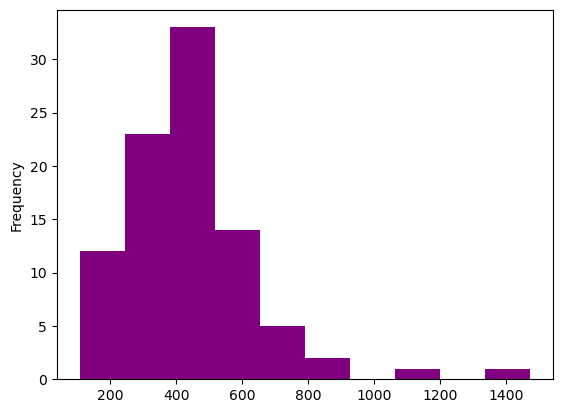

In [23]:
#Precios de la marca isdin
precios_isdin = df_final[df_final.MARCA=="isdin"]["PRECIO"].plot(kind="hist", color="purple")

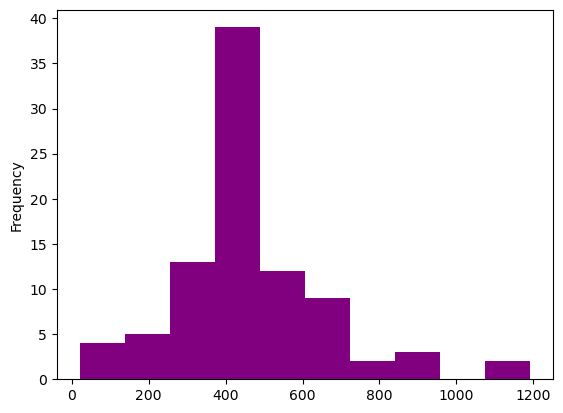

In [24]:
#Precios de la marca avene
precios_avene = df_final[df_final.MARCA=="avene"]["PRECIO"].plot(kind="hist", color="purple")

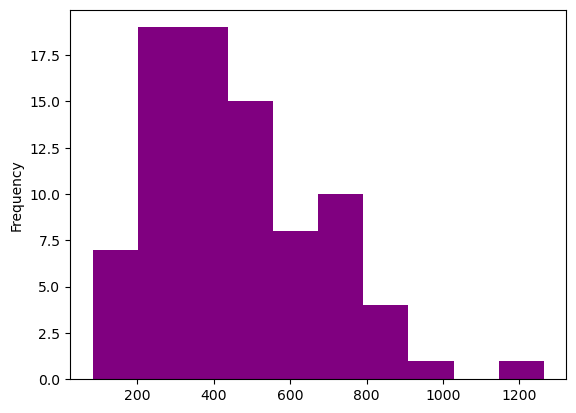

In [25]:
#Precios de la marca eucerin
precios_eucerin = df_final[df_final.MARCA=="eucerin"]["PRECIO"].plot(kind="hist", color="purple")

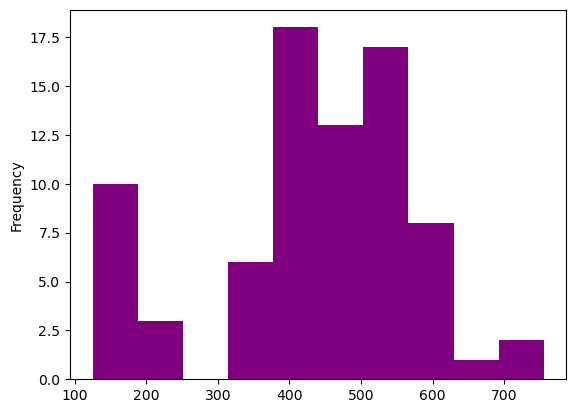

In [26]:
#Precios de la marca bioderma
precios_bioderma = df_final[df_final.MARCA=="bioderma"]["PRECIO"].plot(kind="hist", color="purple")

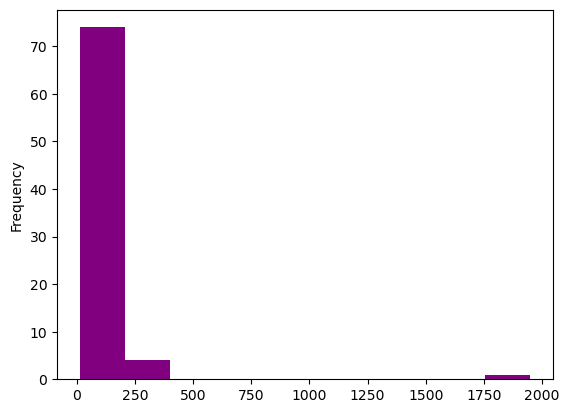

In [27]:
#Precios de la marca nivea
precios_nivea = df_final[df_final.MARCA=="nivea"]["PRECIO"].plot(kind="hist", color="purple")

,MARCA,avg(PRECIO)
0,nivea,87.416667
1,avene,567.416667
2,bioderma,452.791667
3,eucerin,516.000000
4,isdin,468.208333


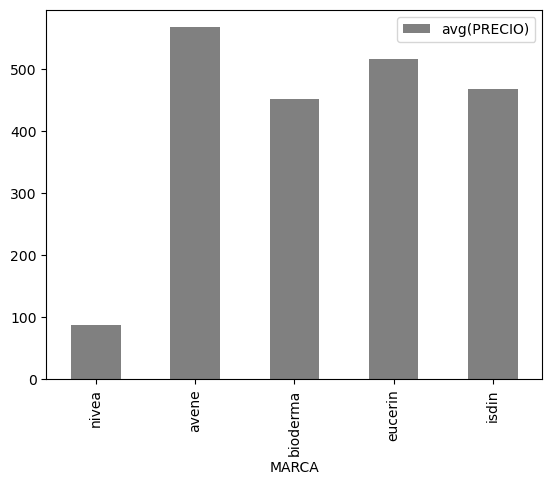

In [28]:
#Promedio de los precios en Farmacia San Pablo

precios_promedios_san_pablo = ps.sqldf("select MARCA, avg(PRECIO) from df_final where AUTOSERVICIO = 'www.farmaciasanpablo.com.mx' group by MARCA order by PRECIO")
precios_promedios_san_pablo.plot.bar(x="MARCA", color = "gray")
precios_promedios_san_pablo

,MARCA,avg(PRECIO)
0,nivea,169.823529
1,bioderma,344.236875
2,isdin,411.844828
3,avene,495.081481
4,eucerin,423.461364


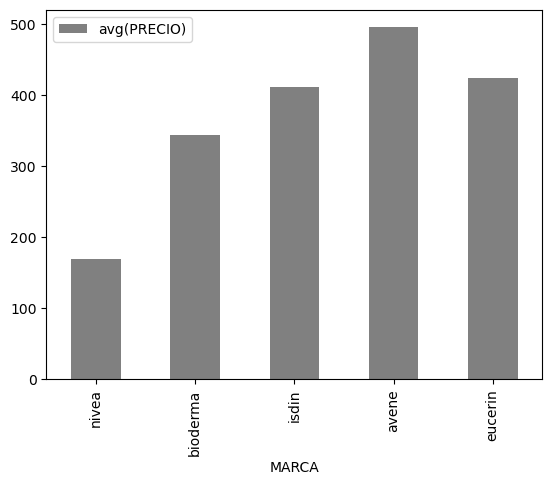

In [29]:
#Promedio de los precios en Farmacia FarmaZone

precios_promedios_farmazone = ps.sqldf("select MARCA, avg(PRECIO) from df_final where AUTOSERVICIO = 'www.farmazone.com.mx' group by MARCA order by PRECIO")

precios_promedios_farmazone.plot.bar(x="MARCA", color = "gray")
precios_promedios_farmazone

,MARCA,avg(PRECIO)
0,nivea,93.8798
1,eucerin,451.9260
2,isdin,452.2714
3,bioderma,459.6652
4,avene,418.9844


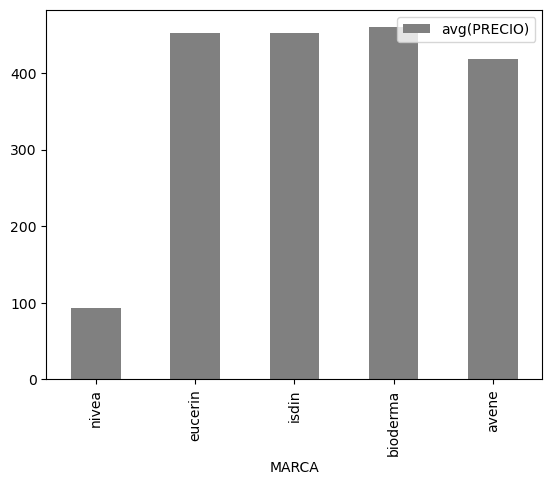

In [30]:
#Promedio de los precios en Farmacia FarmaListo

precios_promedios_farmalisto = ps.sqldf("select MARCA, avg(PRECIO) from df_final where AUTOSERVICIO = 'www.farmalisto.com.mx' group by MARCA order by PRECIO")

precios_promedios_farmalisto.plot.bar(x="MARCA", color = "gray")
precios_promedios_farmalisto

,NOMBRE,AUTOSERVICIO,max(PRECIO)
0,Avène DermAbsolu Bálsamo de Noche Regen...,www.farmaciasanpablo.com.mx,873.0
1,Isdin Isdinceutics Flavo-C Serum Repar Noche c...,www.farmalisto.com.mx,1475.0
2,Dabalash + nivea desmaquillante bifásico de ojos,www.farmazone.com.mx,1950.0


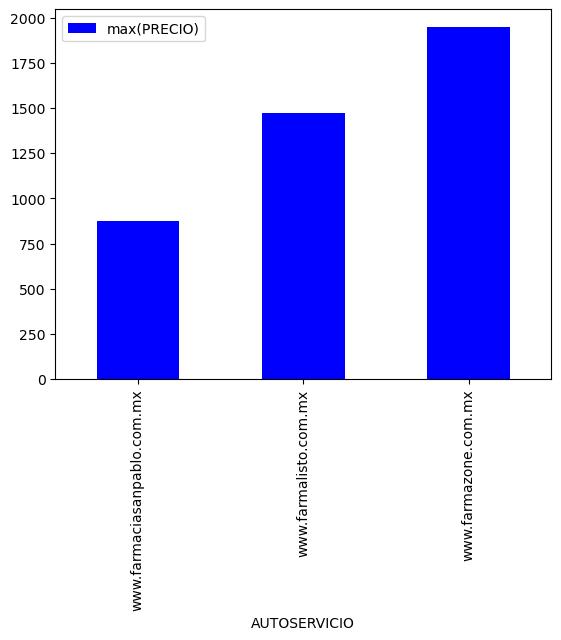

In [31]:
#Precios maximos en cada sitio

precios_maximos = ps.sqldf("select NOMBRE, AUTOSERVICIO, max(PRECIO) from df_final group by AUTOSERVICIO order by PRECIO")
precios_maximos.plot.bar(x="AUTOSERVICIO", color = "blue")

precios_maximos

,NOMBRE,AUTOSERVICIO,min(PRECIO)
0,CREMA NIVEA ACLARADO NATURAL PARA MANOS TUBO C...,www.farmalisto.com.mx,11.6
1,Nivea body milk piel extra seca crema fco. 100ml,www.farmazone.com.mx,26.0
2,Nivea Aclarado Natural Antitranspirante,www.farmaciasanpablo.com.mx,48.5


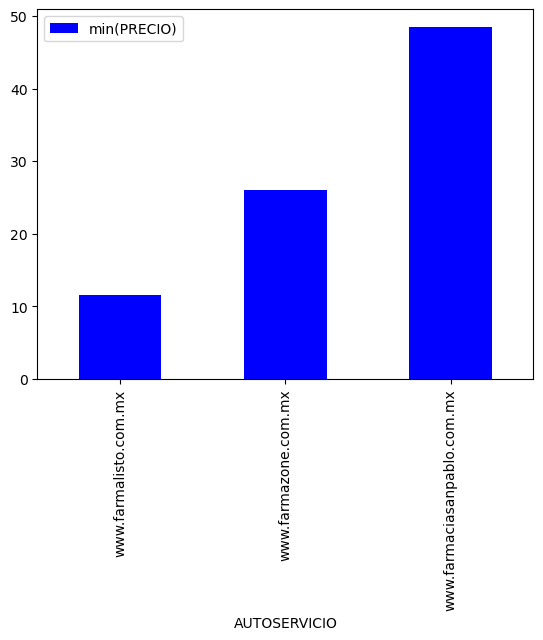

In [32]:
#Precios minimos en cada sitio

precios_minimos = ps.sqldf("select NOMBRE, AUTOSERVICIO, min(PRECIO) from df_final group by AUTOSERVICIO order by PRECIO")

precios_minimos.plot.bar(x="AUTOSERVICIO", color = "blue")
precios_minimos

In [33]:
#Documento excel con los datos del dataframe final
df_final.to_excel("df_final.xlsx",index=False)

In [34]:
#Consulta del nombre y precio de cada producto. Ordenado por precio
ps.sqldf("select NOMBRE, PRECIO from df_final order by PRECIO")

,NOMBRE,PRECIO
0,CREMA NIVEA ACLARADO NATURAL PARA MANOS TUBO C...,11.60
1,CREMA NIVEA LATA CON 20 ML - PIEL,17.01
2,Jabón Ricitos De Oro Avena Coloidal Barra Con ...,20.00
3,NIVEA SOFT MILK PARA PIEL SECA BOTE CON 125 ML,20.30
4,Nivea body milk piel extra seca crema fco. 100ml,26.00
...,...,...
416,Avene kit hidra,1189.00
417,Kit avene piel seca,1193.00
418,Kit eucerin antiedad,1264.01
419,Isdin Isdinceutics Flavo-C Serum Repar Noche c...,1475.00


In [35]:
#Consulta del nombre y precio de todos los productos cuya marca es bioderma en Farmazone
ps.sqldf("select NOMBRE, PRECIO from df_final where AUTOSERVICIO= 'www.farmazone.com.mx' and MARCA='bioderma'")

,NOMBRE,PRECIO
0,Gel limpiador bioderma sebium gel moussant act...,399.00
1,Kit bioderma sensibio h2o agua micelar,504.99
2,Gel bioderma sebium moussant con 100 ml,182.00
3,Crema bioderma sensibio ar con 40 ml,473.00
4,Crema bioderma sebium pore refiner con 30 ml,535.00
5,Bioderma sensibio gel m tub c/100ml,187.00
6,Bioderma sensibio gel espumo btl c/200ml,354.00
7,Bioderma sebium hydra tub c/40ml,393.00
8,Bioderma sebium gel bot c/500ml,460.00
9,Bioderma atoderm pain caj c/150g,139.00


In [36]:
#Consulta del nombre y precio de todos los productos cuya precio es menor a 200
ps.sqldf("select NOMBRE, PRECIO from df_final where PRECIO<200")

,NOMBRE,PRECIO
0,Isdin Ureadin Crema De Manos Plus,126.50
1,Isdin Germisdin Gel de Higiene Intima,176.00
2,Avène TriXera Nutrition Jabón Limpiador,154.00
3,Avène XeraCalm A.D Jabón de Limpieza Fa...,185.00
4,Avène Cleanance Jabón Limpiador Piel co...,149.00
...,...,...
102,Antitranspirante Nívea Men Stress Protect Aero...,64.26
103,Antitranspirante Nivea Dry Impact Roll-On Con ...,27.84
104,Antitranspirante Nivea Aclarado 48H Roll-On Co...,34.00
105,Antitranspirante Nivea Aclarado Natural Roll-O...,33.00


In [37]:
#Consulta del nombre, marca y precio de todos los productos cuya precio es mayor o igual a 200 y menor o igual a 500
ps.sqldf("select NOMBRE, MARCA, PRECIO from df_final where PRECIO>=200 and PRECIO<=500")

,NOMBRE,MARCA,PRECIO
0,Isdin Si-Nails Fortalecedor de uñas,isdin,432.50
1,Isdin Instant Flash Suero Antiedad Efec...,isdin,303.00
2,Isdin Hialuronic Booster Serúm Antiedad...,isdin,357.00
3,Isdin Germisdin Aloe Vera Gel De Baño P...,isdin,290.50
4,Avène Gel Exfoliante Para Pieles Sensib...,avene,439.00
...,...,...,...
196,Bloqueador Nivea Sun Fps30 200 ml. 2En,nivea,253.00
197,Bloqueador Nivea Sun Facial Fps 50,nivea,204.16
198,Protec Nivea Sun P-Sen Fps50 2,nivea,275.00
199,Protec Nivea Sun Hidr Fps50 20,nivea,253.00


In [38]:
#Consulta del nombre, marca y precio de todos los productos cuya precio es mayor a 500
ps.sqldf("select NOMBRE, PRECIO from df_final where PRECIO>500")

,NOMBRE,PRECIO
0,Isdin Lambdacaps Suplemento Alimenticio,799.5
1,Isdin Fusion Water Urban Protector Solar,623.5
2,Isdin Fotoprotector FPS50+ Gel Cream Pa...,645.0
3,Isdin Fusion Water Fotoprotector Facial...,580.0
4,Isdin Foto Ultra Age Repair Fusion Wate...,599.0
...,...,...
108,Kit Photoderm Cover Touch Claro + Sensibio H2O...,511.0
109,Sensibio H2O Bomba Inversa 500 mL,585.0
110,Sensibio Gel Espumoso 500 mL,526.0
111,Sébium Global Limpiador Anti-Imperfecciones 30 mL,559.0


In [39]:
#Consulta del nombre, marca, sitio y precio sin descuento de todos los productos con descuento
ps.sqldf("select NOMBRE, MARCA, AUTOSERVICIO, PRECIO_SIN_DESCUENTO from df_final where MARCA ='isdin' and PRECIO_SIN_DESCUENTO>0")

,NOMBRE,MARCA,AUTOSERVICIO,PRECIO_SIN_DESCUENTO
0,Isdin Ureadin Crema De Manos Plus,isdin,www.farmaciasanpablo.com.mx,149.0
1,Isdin Si-Nails Fortalecedor de uñas,isdin,www.farmaciasanpablo.com.mx,509.0
2,Isdin Germisdin Gel de Higiene Intima,isdin,www.farmaciasanpablo.com.mx,220.0
3,Isdin Instant Flash Suero Antiedad Efec...,isdin,www.farmaciasanpablo.com.mx,357.0
4,Isdin Germisdin Aloe Vera Gel De Baño P...,isdin,www.farmaciasanpablo.com.mx,363.5
5,Isdin Foto Ultra Age Repair Fusion Wate...,isdin,www.farmaciasanpablo.com.mx,705.0
6,Isdin FLAVO-C MELATONIN SÉRUM REPARADOR...,isdin,www.farmaciasanpablo.com.mx,857.5
7,Isdin gel cream fps 50 tub c/250ml,isdin,www.farmazone.com.mx,490.0
8,Isdin compact 50+color ar sob c/10gr,isdin,www.farmazone.com.mx,415.0
9,Crema facial isdin nutratopic pro-amp con 50 ml,isdin,www.farmazone.com.mx,547.0


In [40]:
#Consulta del nombre, marca, sitio y precio de todos los productos de la marca nivea y con precio menor o igual a 500
ps.sqldf("select NOMBRE, MARCA, AUTOSERVICIO, PRECIO from df_final where MARCA='nivea' and PRECIO<=500")

,NOMBRE,MARCA,AUTOSERVICIO,PRECIO
0,Nivea,nivea,www.farmaciasanpablo.com.mx,68.50
1,Nivea Crema corporal,nivea,www.farmaciasanpablo.com.mx,98.00
2,Nivea Crema corporal Jumbo,nivea,www.farmaciasanpablo.com.mx,158.50
3,Nivea Aclarado Natural Antitranspirante,nivea,www.farmaciasanpablo.com.mx,48.50
4,Nivea Mujer Aclarado natural,nivea,www.farmaciasanpablo.com.mx,68.00
...,...,...,...,...
73,Antitranspirante Nívea Men Stress Protect Aero...,nivea,www.farmalisto.com.mx,64.26
74,Antitranspirante Nivea Dry Impact Roll-On Con ...,nivea,www.farmalisto.com.mx,27.84
75,Antitranspirante Nivea Aclarado 48H Roll-On Co...,nivea,www.farmalisto.com.mx,34.00
76,Antitranspirante Nivea Aclarado Natural Roll-O...,nivea,www.farmalisto.com.mx,33.00


In [41]:
#Consulta del nombre, marca, sitio y precio sin descuento de todos los productos con disponibilidad
ps.sqldf("select NOMBRE, MARCA, AUTOSERVICIO, PRECIO from df_final where DISPONIBILIDAD != 'Lo sentimos, producto no disponible'")

,NOMBRE,MARCA,AUTOSERVICIO,PRECIO
0,Isdin Lambdacaps Suplemento Alimenticio,isdin,www.farmaciasanpablo.com.mx,799.50
1,Isdin Ureadin Crema De Manos Plus,isdin,www.farmaciasanpablo.com.mx,126.50
2,Isdin Si-Nails Fortalecedor de uñas,isdin,www.farmaciasanpablo.com.mx,432.50
3,Isdin Germisdin Gel de Higiene Intima,isdin,www.farmaciasanpablo.com.mx,176.00
4,Isdin Fusion Water Urban Protector Solar,isdin,www.farmaciasanpablo.com.mx,623.50
...,...,...,...,...
383,Antitranspirante Nívea Men Stress Protect Aero...,nivea,www.farmalisto.com.mx,64.26
384,Antitranspirante Nivea Dry Impact Roll-On Con ...,nivea,www.farmalisto.com.mx,27.84
385,Antitranspirante Nivea Aclarado 48H Roll-On Co...,nivea,www.farmalisto.com.mx,34.00
386,Antitranspirante Nivea Aclarado Natural Roll-O...,nivea,www.farmalisto.com.mx,33.00


In [42]:
#Consulta del nombre, marca, sitio y precio maximo y minimo de la marca avene
ps.sqldf("select NOMBRE, MARCA, AUTOSERVICIO, max(PRECIO), min(PRECIO) from df_final where MARCA= 'avene'")

,NOMBRE,MARCA,AUTOSERVICIO,max(PRECIO),min(PRECIO)
0,Jabón Ricitos De Oro Avena Coloidal Barra Con ...,avene,www.farmalisto.com.mx,1193.0,20.0
